### Required Modules

In [1]:
import torch.nn.functional as F 
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import numpy as np
import os

### Dataset And Dataloader

In [2]:
rand_seed = 3407
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)

data_folder = 'brain_dead_synthetic'
# /home/sysadm/Workspace/Brain Dead/data/brain_dead_emotion_detection/AUG_Train
sets = ["Train", "Test"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

num_classes = 4
batch_size = 4
epochs = 50
lr = 0.0001
image_size= 299
n_workers = 10



data_transform = {
    sets[0]: transforms.Compose([
        transforms.Resize(image_size),

        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),

        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=0.5, hue=0.3),
        transforms.RandomRotation(50),
        
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        
        transforms.RandomErasing(p=0.4),

        ]),
    sets[1]: transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])
}
data_dir = os.path.join('./data', data_folder)
image_dataset = {x: datasets.ImageFolder(
    os.path.join(data_dir, x), data_transform[x]) for x in sets}

dataloaders = {x: torch.utils.data.DataLoader(
    image_dataset[x], batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True) for x in sets}

dataset_size = {x: len(image_dataset[x]) for x in sets}

### Bi-Linear Convolution Neural Network Model, backboned with resnet18 (Trained on IMAGENET)

In [3]:
class BCNN(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(BCNN, self).__init__()
        features = torchvision.models.resnet18(pretrained=pretrained)
        self.conv = nn.Sequential(*list(features.children())[:-2])

        self.fc = nn.Sequential(
            nn.Linear(512 * 512, 256),
            nn.Dropout(0.3),
            nn.LeakyReLU(),
            nn.Linear(256, 16),
            nn.LeakyReLU(),
            nn.Linear(16, num_classes)
            )
        

    def forward(self, input):
        features = self.conv(input)
        features = features.view(features.size(0), 512, 10 * 10)
        features_T = torch.transpose(features, 1, 2)
        features = torch.bmm(features, features_T) / (10 * 10)
        features = features.view(features.size(0), 512 * 512)
        features = torch.sign(features) * torch.sqrt(torch.abs(features) + 1e-12)
        features = torch.nn.functional.normalize(features)
        out = self.fc(features)
        return out

model = BCNN(num_classes=num_classes)

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Getting Predictions on Test Data

In [8]:
checkpoint = torch.load('./output/best_model_synthetic_wAugT.pt')
model = BCNN(num_classes=num_classes)

model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval()

running_correct = 0
y_true, y_pred = [], []
for input, label in dataloaders[sets[1]]:
    input = input.to(device)
    label = label.to(device)

    with torch.no_grad():
        output = model(input)
        _, pred = torch.max(output, 1)

        running_correct += torch.sum(pred == label.data)

        y_true += label.tolist()
        y_pred += pred.tolist()
    
    acc = running_correct.double() / dataset_size[sets[1]]
    
print(f'Accuracy: {acc}')

Accuracy: 0.42005420054200543


### Precision, Recall, F1-score, Suppoort, Accuracy

In [5]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.06      0.11        80
           1       0.52      0.57      0.54       105
           2       0.62      0.20      0.30       102
           3       0.33      0.85      0.48        82

    accuracy                           0.42       369
   macro avg       0.49      0.42      0.36       369
weighted avg       0.50      0.42      0.37       369



### Confusion Matrix

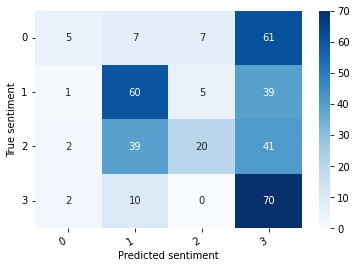

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')
   
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

show_confusion_matrix(df_cm)
